In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Nhập dữ liệu từ dataset

In [44]:
data = pd.read_csv('News.csv',index_col=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [47]:
data['class'].value_counts()

0    23502
1    21417
Name: class, dtype: int64

tiền xử lý dữ liệu
Hình dạng của tập dữ liệu có thể được tìm thấy bằng mã bên dưới.

In [30]:
data.shape

(44919, 5)

Vì tiêu đề, chủ đề và cột ngày sẽ không hữu ích trong việc xác định tin tức. Vì vậy, chúng ta có thể bỏ các cột này. Python3

In [31]:
data = data.drop(["title", "subject","date"], axis = 1)


Bây giờ, chúng tôi phải kiểm tra xem có bất kỳ giá trị null nào không (chúng tôi sẽ loại bỏ các hàng đó)

In [32]:
data.isnull().sum()


text     0
class    0
dtype: int64

Vì vậy, không có giá trị null.
  Bây giờ chúng ta phải xáo trộn tập dữ liệu để ngăn mô hình bị sai lệch.
  Sau đó, chúng tôi sẽ đặt lại chỉ mục và sau đó loại bỏ nó.
  Bởi vì cột chỉ mục không hữu ích cho chúng tôi.

In [33]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)  
data.drop(["index"], axis=1, inplace=True)

Bây giờ, hãy kiểm tra các giá trị duy nhất trong từng danh mục bằng mã bên dưới.

<AxesSubplot: xlabel='class', ylabel='count'>

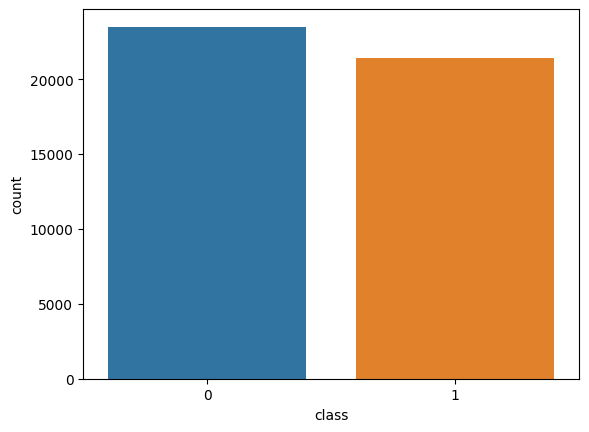

In [35]:
sns.countplot(data=data,
			x='class',
			order=data['class'].value_counts().index)

Tiền xử lý và phân tích cột Tin tức
Đầu tiên, chúng tôi sẽ xóa tất cả 'stopwords', dấu chấm câu và mọi khoảng trắng không liên quan khỏi văn bản. Đối với Thư viện NLTK đó là bắt buộc và một số mô-đun của nó cần được tải xuống.

In [36]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /Users/letiendat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/letiendat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Khi chúng tôi có tất cả các mô-đun cần thiết, chúng tôi có thể tạo văn bản tiền xử lý tên hàm.
Hàm này sẽ xử lý trước tất cả dữ liệu được cung cấp dưới dạng đầu vào.

In [37]:
def preprocess_text(text_data):
	preprocessed_text = []
	
	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text

Hàm dưới đây thực hiện chức năng trong tất cả các tin tức trong cột văn bản

In [40]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [13:36<00:00, 55.00it/s]


Hãy trực quan hóa WordCloud cho tin tức giả và thật một cách riêng biệt.

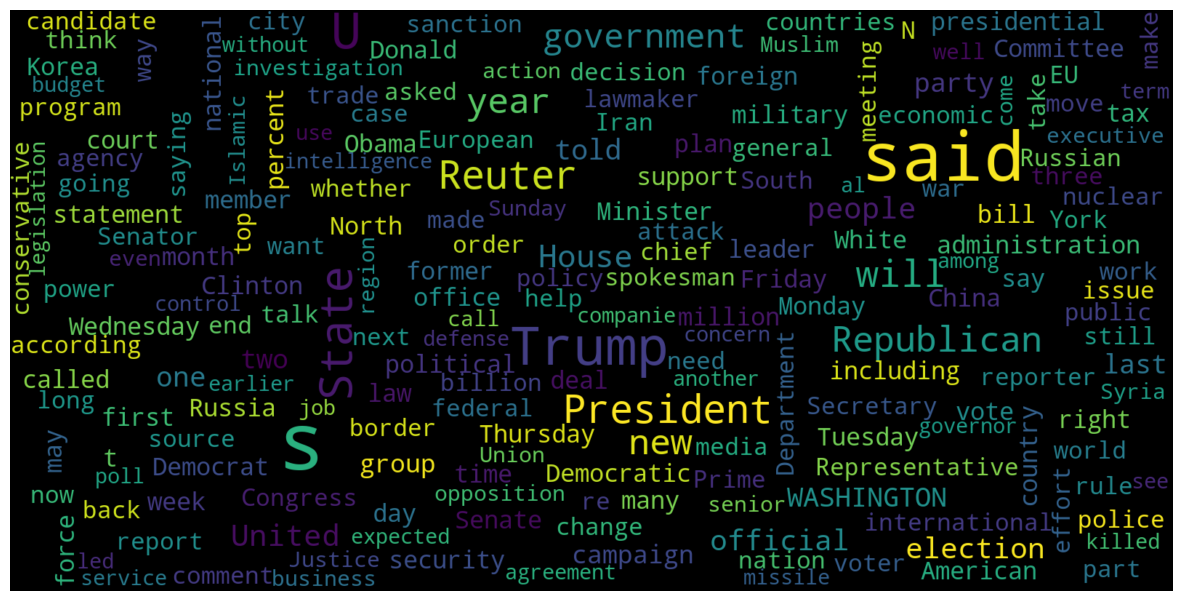

In [38]:
# Real
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


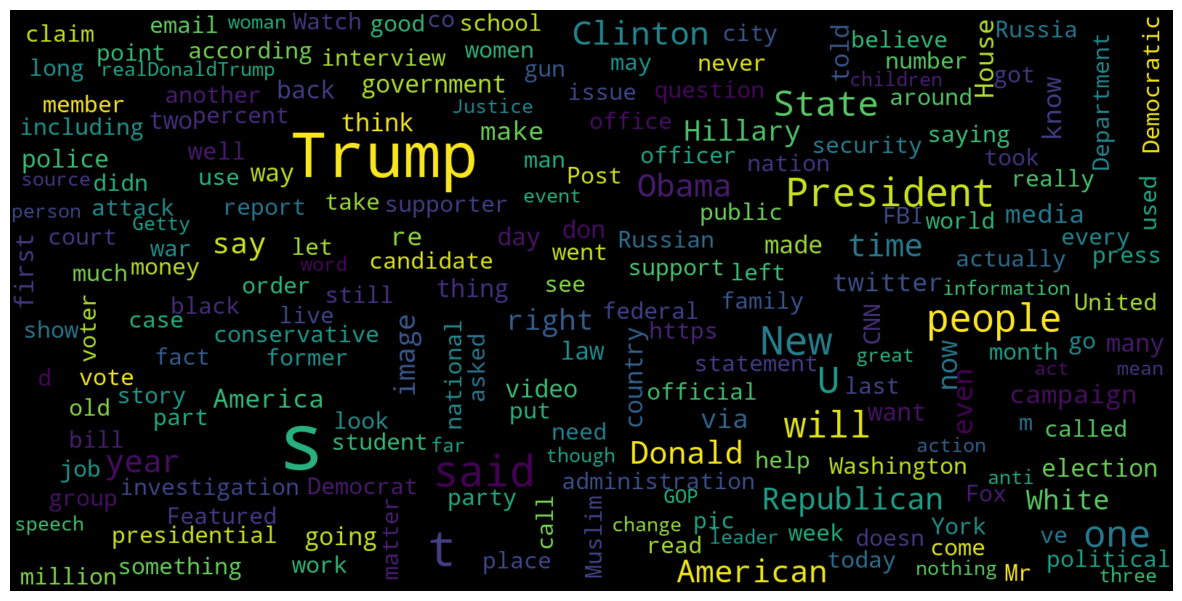

In [39]:
# Fake
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


vẽ đồ thị của 20 từ thường xuyên nhất.

<AxesSubplot: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

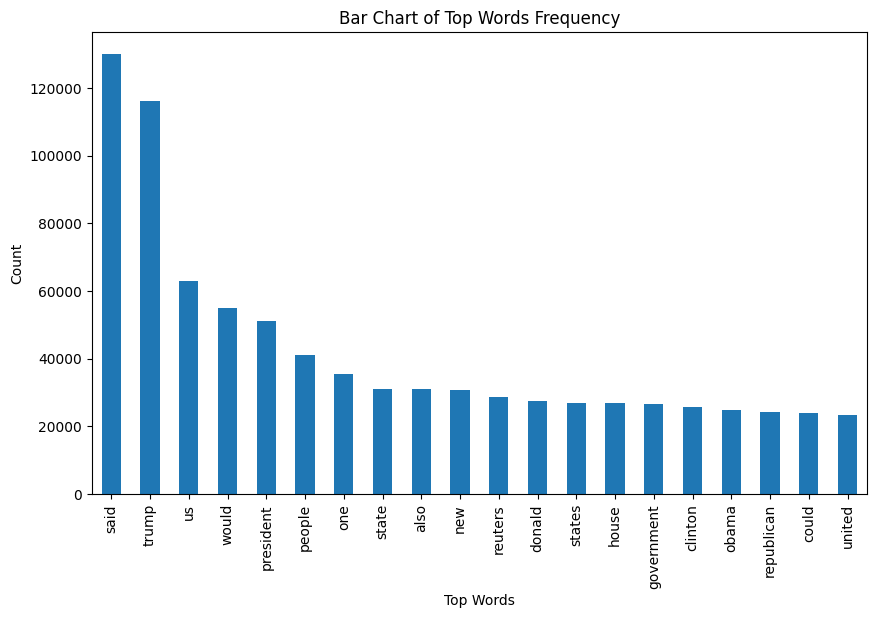

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
	vec = CountVectorizer().fit(corpus)
	bag_of_words = vec.transform(corpus)
	sum_words = bag_of_words.sum(axis=0)
	words_freq = [(word, sum_words[0, idx])
				for word, idx in vec.vocabulary_.items()]
	words_freq = sorted(words_freq, key=lambda x: x[1],
						reverse=True)
	return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
	kind='bar',
	figsize=(10, 6),
	xlabel="Top Words",
	ylabel="Count",
	title="Bar Chart of Top Words Frequency"
)

Chuyển đổi văn bản thành Vector
Trước khi chuyển đổi dữ liệu thành vectơ, hãy chia nó thành train và test.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data['text'],
													data['class'],
													test_size=0.25)

Bây giờ chúng ta có thể chuyển đổi dữ liệu đào tạo thành vectơ bằng TfidfVectorizer.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

Đào tạo mô hình, đánh giá và dự đoán
Bây giờ, tập dữ liệu đã sẵn sàng để huấn luyện mô hình.

Để đào tạo, chúng tôi sẽ sử dụng Hồi quy logistic và đánh giá độ chính xác của dự đoán bằng cách sử dụng precision_score.

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9936774614859449
0.990026714158504


Let’s train with Decision Tree Classifier. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

1.0
0.9971504897595725


Ma trận nhiễu cho Trình phân loại cây quyết định có thể được triển khai:

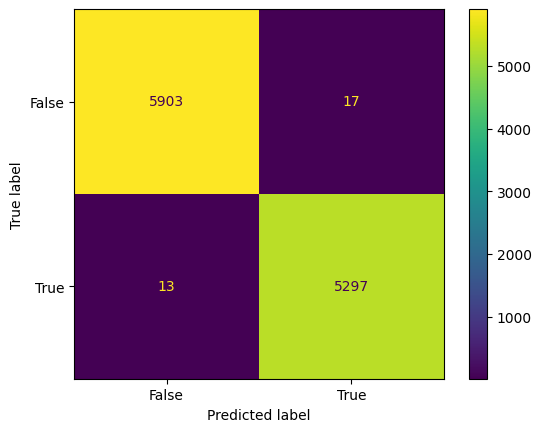

In [ ]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()